# AAPL DNN

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


## Collect the data

In [2]:
input_window_size = 10  # this is the no. of input nodes of the NN
start_date = '2010-01-01'
end_date = '2020-12-29'
dates = pd.date_range(start_date, end_date)

In [5]:
filter_dates = pd.DataFrame(index=dates)
df = pd.read_csv('data/Pre_Processed_AAPL.csv', index_col='Date', parse_dates=True,
                    usecols=['Date', 'Adj. Close'], na_values=['nan'])
df = filter_dates.join(df)
df.head()

,Adj. Close
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,NaN
2010-01-04,6.470741
2010-01-05,6.481928


## Feature Engineering

In [6]:
df.isna().sum()

Adj. Close    1249
dtype: int64

In [7]:
df = df.dropna()
df.isna().sum()

Adj. Close    0
dtype: int64

In [8]:
df.shape

(2767, 1)

## Normalize the data

In [10]:
# Normalization and Denormalization constants
denorm_const = df['Adj. Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(6.470741272, 0.15454179945768662)

In [11]:
# Normalize
df = df*norm_const
df.head()

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.001729
2010-01-06,0.985795
2010-01-07,0.983973
2010-01-08,0.990515


## Bollinger Bands

In [12]:
# get_rolling_mean(df_, window): Hàm này tính trung bình trượt của DataFrame df_ với một cửa sổ có độ dài là window. Trung bình trượt là trung bình cộng của các giá trị trong cửa sổ trượt.

# get_rolling_std(df_, window): Hàm này tính độ lệch chuẩn trượt của DataFrame df_ với một cửa sổ có độ dài là window. Độ lệch chuẩn trượt là độ đo của sự biến động của dữ liệu trong một khoảng cửa sổ trượt.

# get_bollinger_bands(rm, rstd): Hàm này tính toán Bollinger Bands sử dụng trung bình trượt (rm) và độ lệch chuẩn trượt (rstd). Bollinger Bands là một khoảng dự đoán xung quanh trung bình trượt, thường được định nghĩa bởi trung bình trượt cộng hoặc trừ một số đa lệch chuẩn.

# clip_to_bollinger_bands(df_, window): Hàm này tính toán Bollinger Bands cho DataFrame df_ với cửa sổ trượt có độ dài window và sau đó cắt giá trị của DataFrame lại trong khoảng Bollinger Bands. Điều này có nghĩa là mọi giá trị nằm ngoài khoảng Bollinger Bands sẽ được cắt đi để giữ cho chúng nằm trong khoảng đó.
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [13]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

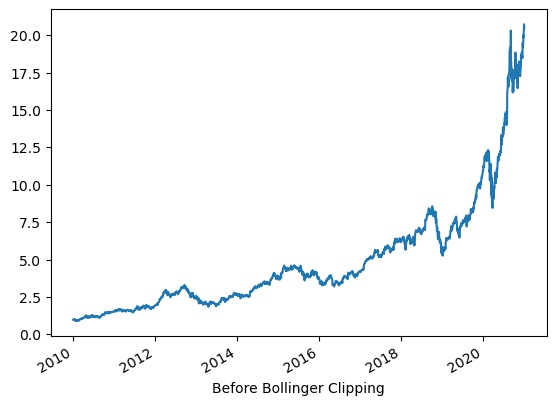

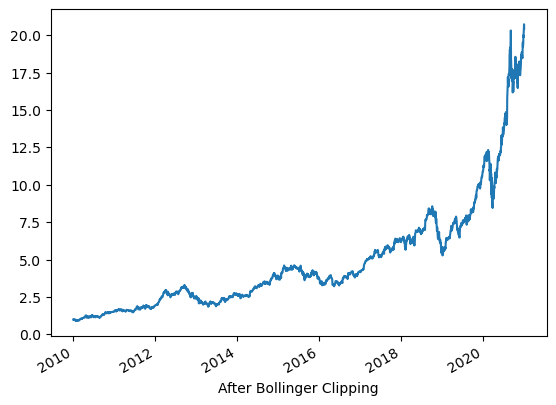

In [14]:
# plot_df(df, "Before Bollinger Clipping"): Đầu tiên, hàm plot_df được gọi với tham số df là DataFrame và tiêu đề "Before Bollinger Clipping". Điều này có nghĩa là đồ thị của DataFrame sẽ được vẽ và hiển thị trước khi thực hiện quá trình Bollinger Clipping (cắt giới hạn Bollinger).

# df = clip_to_bollinger_bands(df, input_window_size): Sau đó, DataFrame df được truyền vào hàm clip_to_bollinger_bands để thực hiện quá trình cắt giới hạn Bollinger. Kết quả của quá trình này được gán lại cho df. Nghĩa là DataFrame df sau khi đã được cắt giới hạn Bollinger sẽ được lưu lại trong biến df.

# plot_df(df, "After Bollinger Clipping"): Cuối cùng, hàm plot_df được gọi lần thứ hai với tham số df (đã được cập nhật sau khi cắt giới hạn Bollinger) và tiêu đề "After Bollinger Clipping". Điều này có nghĩa là đồ thị của DataFrame sau khi đã được cắt giới hạn Bollinger sẽ được vẽ và hiển thị.
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

<!-- 
Khi chúng ta thực hiện quá trình Bollinger Clipping trên DataFrame, đôi khi một số phần tử trong DataFrame có thể được cắt giới hạn Bollinger và trở thành NaN (Not a Number), có nghĩa là chúng không có giá trị hợp lệ.

Trong thông điệp "After Bollinger Clipping we have first (input_window_size - 1) elements as NaN", điều này có nghĩa là sau khi đã thực hiện Bollinger Clipping, một số phần tử ban đầu của DataFrame sẽ trở thành NaN. Số lượng các phần tử này sẽ là (input_window_size - 1). Điều này xảy ra vì khi thực hiện cắt giới hạn Bollinger, các giá trị không rơi vào phạm vi giới hạn sẽ được đặt thành NaN, và trong trường hợp này, số lượng các giá trị NaN này sẽ bằng input_window_size trừ đi 1. -->
After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [15]:

df.head(15)

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.001729
2010-01-06,0.985795
2010-01-07,0.983973
2010-01-08,0.990515
2010-01-11,0.981777
2010-01-12,0.970609
2010-01-13,0.984300
2010-01-14,0.978599
2010-01-15,0.962245


In [16]:

# Phương thức isna() được gọi trên DataFrame (df) để tạo ra một DataFrame mới, trong đó mỗi phần tử sẽ là True nếu nó là NaN và False nếu không phải.

# Phương thức sum() được gọi sau isna() để tính tổng số lượng giá trị True (NaN) cho mỗi cột trong DataFrame.

# Do đó, df.isna().sum() sẽ trả về một Series, trong đó mỗi giá trị sẽ là tổng số lượng giá trị NaN trong mỗi cột tương ứng của DataFrame df. Điều này hữu ích để kiểm tra xem có bao nhiêu giá trị NaN trong mỗi cột của DataFrame, giúp phát hiện và xử lý dữ liệu thiếu.
df.isna().sum()

Adj. Close    0
dtype: int64

In [17]:
df = df.dropna()
print(df.isna().sum())
print(df.shape)

Adj. Close    0
dtype: int64
(2767, 1)


In [19]:
data = list(df['Adj. Close'])
len(data)

2767

## Train, Validation and Test data

### For DNN

Train+Validation : Test = 80 : 20

In [20]:
# train_till = int(0.8*len(data)): Đầu tiên, một biến train_till được tính toán bằng cách nhân độ dài của dữ liệu (data) với 0.8 (80%), và sau đó chuyển đổi thành một số nguyên (bằng cách sử dụng int()) để đại diện cho chỉ số của dữ liệu cuối cùng trong tập huấn luyện và tập validation.

# train_raw_data = data[:train_till]: Dữ liệu từ đầu đến chỉ số train_till được gán cho biến train_raw_data, đại diện cho tập huấn luyện và tập validation.

# test_raw_data = data[train_till:]: Dữ liệu từ chỉ số train_till đến cuối cùng của dữ liệu được gán cho biến test_raw_data, đại diện cho tập kiểm tra.

# train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]: Tập huấn luyện được chia thành các đặc trưng (features), mỗi đặc trưng là một dãy con gồm input_window_size phần tử trong tập huấn luyện.

# test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]: Tương tự, tập kiểm tra cũng được chia thành các đặc trưng, mỗi đặc trưng là một dãy con gồm input_window_size phần tử trong tập kiểm tra.

# train_labels = train_raw_data[input_window_size:]: Nhãn (labels) tương ứng với các đặc trưng trong tập huấn luyện được xác định bằng cách lấy các phần tử sau input_window_size của train_raw_data.

# test_labels = test_raw_data[input_window_size:]: Tương tự, nhãn tương ứng với các đặc trưng trong tập kiểm tra được xác định bằng cách lấy các phần tử sau input_window_size của test_raw_data.

# Cuối cùng, print(len(train_features), len(train_labels)) và print(len(test_features), len(test_labels)) được sử dụng để in ra số lượng các đặc trưng và nhãn trong tập huấn luyện và tập kiểm tra tương ứng.
train_till = int(0.8*len(data))  # this is train + validation

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

2203 2203
544 544


In [21]:
# Trong đoạn mã trên, các đặc trưng và nhãn đã được chuyển đổi thành đối tượng DataFrame của thư viện pandas để thuận tiện cho việc xử lý dữ liệu và thực hiện các thao tác phân tích.

# train_features = pd.DataFrame.from_records(train_features): Tập huấn luyện train_features, đã là một danh sách các đặc trưng, được chuyển đổi thành DataFrame bằng cách sử dụng phương thức from_records() của pandas. Mỗi hàng của DataFrame mới sẽ là một mẫu dữ liệu, trong đó mỗi cột đại diện cho một đặc trưng.

# test_features = pd.DataFrame.from_records(test_features): Tương tự, tập kiểm tra test_features cũng được chuyển đổi thành DataFrame tương tự như tập huấn luyện.

# train_labels = pd.DataFrame(train_labels): Tập nhãn huấn luyện train_labels, đã là một danh sách các nhãn, cũng được chuyển đổi thành DataFrame. DataFrame này sẽ chỉ có một cột, trong đó mỗi hàng là một nhãn tương ứng với một mẫu dữ liệu trong tập huấn luyện.

# test_labels = pd.DataFrame(test_labels): Tương tự, tập nhãn kiểm tra test_labels cũng được chuyển đổi thành DataFrame tương tự như tập nhãn huấn luyện.
train_features = pd.DataFrame.from_records(train_features)
test_features = pd.DataFrame.from_records(test_features)

train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(2203, 10) (2203, 1)
(544, 10) (544, 1)


## Build the model

In [22]:
# Trong đoạn mã trên, một hàm build_model() được định nghĩa để tạo ra một mô hình mạng nơ-ron sử dụng thư viện TensorFlow/Keras.

# model = keras.Sequential([...]): Mô hình được khởi tạo dưới dạng một chuỗi tuần tự của các lớp (sequential model) bằng cách sử dụng keras.Sequential(). Trong trường hợp này, mô hình có ba lớp:

# Lớp đầu tiên (keras.layers.Dense(10, activation=tf.nn.relu, input_shape=[input_window_size])) là một lớp dense (hoặc fully connected) với 10 đơn vị nơ-ron, hàm kích hoạt relu và input_shape là [input_window_size], xác định kích thước của đầu vào cho mô hình.

# Lớp thứ hai (keras.layers.Dense(5, activation=tf.nn.relu)) là một lớp dense với 5 đơn vị nơ-ron và hàm kích hoạt relu.

# Lớp thứ ba (keras.layers.Dense(1)) là một lớp dense với 1 đơn vị nơ-ron, không có hàm kích hoạt được chỉ định, điều này có nghĩa là mô hình sẽ xuất ra đầu ra dạng số.

# model.compile(loss='mean_squared_error', optimizer='adam'): Sau khi đã xây dựng mô hình, hàm này được sử dụng để biên dịch mô hình với các tham số quan trọng như hàm mất mát (loss function) và bộ tối ưu hóa (optimizer). Trong trường hợp này, hàm mất mát được đặt là 'mean_squared_error' (tính toán sự chênh lệch bình phương trung bình giữa các giá trị dự đoán và các giá trị thực tế), và optimizer được chọn là 'adam', một biến thể của phương pháp tối ưu hóa gradient descent.

# Cuối cùng, hàm build_model() trả về mô hình đã được biên dịch để sử dụng trong quá trình huấn luyện và dự đoán.
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation=tf.nn.relu, input_shape=[input_window_size]),
        keras.layers.Dense(5, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


## Train the model

### Without Early Stopping

In [25]:

# Trong đoạn mã trên:

# n_epochs = 500: Đây là số lượng epochs (vòng lặp qua toàn bộ tập dữ liệu) được định nghĩa để huấn luyện mô hình.

# class PrintDot(keras.callbacks.Callback): Đây là một subclass của lớp keras.callbacks.Callback. Nó được sử dụng để tạo ra một callback, tức là một hàm sẽ được gọi trong quá trình huấn luyện để thực hiện các hành động nhất định. Trong trường hợp này, hàm on_epoch_end sẽ được gọi sau mỗi epoch.

# def on_epoch_end(self, epoch, logs): Đây là phương thức được gọi sau mỗi epoch trong quá trình huấn luyện. Nó nhận các tham số epoch (số thứ tự của epoch) và logs (một từ điển chứa các metric như loss và accuracy).

# if epoch % 50 == 0: print(): Nếu epoch chia hết cho 50 (tức là epoch là bội số của 50), một dòng trống sẽ được in ra để tạo ra định dạng cho việc in ra các dấu chấm.

# print('.', end=''): Mỗi lần gọi print('.'), một dấu chấm sẽ được in ra trên c

# ổng console để chỉ ra rằng một epoch đã được hoàn thành.

# history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2, verbose=0, callbacks=[PrintDot()]): Đây là lệnh để huấn luyện mô hình. Dữ liệu huấn luyện (train_features và train_labels) được truyền vào phương thức fit(). epochs=n_epochs xác định số lượng epochs được sử dụng trong quá trình huấn luyện. validation_split=0.2 xác định tỷ lệ dữ liệu được sử dụng cho tập validation, ở đây là 20% của dữ liệu huấn luyện. verbose=0 chỉ định cách hiển thị thông tin trong quá trình huấn luyện (trong trường hợp này là không hiển thị thông tin). Cuối cùng, callback PrintDot() được truyền vào để in ra các dấu chấm sau mỗi epoch.
n_epochs = 500
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print()
        print('.', end='')

history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[PrintDot()])

In [26]:

# Đoạn mã trên tạo ra một DataFrame từ object history được trả về sau quá trình huấn luyện mô hình. DataFrame này chứa các thông tin về các metric (ví dụ: loss và accuracy) được thu thập sau mỗi epoch trong quá trình huấn luyện.

# Dòng cuối cùng của DataFrame này được in ra bằng cách sử dụng phương thức tail(), cho phép chúng ta xem thông tin về các metric ở các epochs gần nhất.

# Thông tin cụ thể về mỗi metric được thu thập sau mỗi epoch được lưu trong các cột của DataFrame hist. Cột 'epoch' lưu trữ số thứ tự của epoch tương ứng.

# Đoạn mã trên là một cách tiện lợi để kiểm tra sự tiến triển của mô hình qua các epochs và đánh giá hiệu suất của nó.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,0.002138,0.007476,495
496,0.002096,0.010277,496
497,0.002089,0.007089,497
498,0.002174,0.007383,498
499,0.002133,0.008123,499


In [27]:
hist.head()

,loss,val_loss,epoch
0,0.002244,0.007638,0
1,0.002207,0.007924,1
2,0.002164,0.007568,2
3,0.002245,0.007277,3
4,0.002213,0.010300,4


In [28]:

# Hàm plot_history(history) này được sử dụng để vẽ đồ thị biểu diễn sự tiến triển của loss function của mô hình trên tập huấn luyện và tập validation qua các epoch.

# Đầu tiên, một DataFrame hist được tạo từ object history chứa thông tin về loss function của mô hình trên cả tập huấn luyện và tập validation sau mỗi epoch.
# Sau đó, một figure mới được tạo ra để chứa đồ thị.
# Label cho trục x được đặt là 'Epoch'.
# Label cho trục y được đặt là 'Loss'.
# Hai đường đồ thị được vẽ: một là loss trên tập huấn luyện và một là loss trên tập validation. Các giá trị loss này được lấy từ cột 'loss' và 'val_loss' trong DataFrame hist tương ứng.
# Cuối cùng, legend được thêm vào để cho biết mỗi đường đồ thị tượng trưng cho một loại loss function.
# Các dòng bị comment trong hàm này là các dòng được sử dụng để điều chỉnh đồ thị, như là chuyển đổi đơn vị của loss function hoặc giới hạn của trục y. Điều này có thể được thực hiện nếu cần thiết cho mục đích hiển thị hoặc đánh giá hiệu suất của mô hình.
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Loss  x($10^{-6}$)')
    plt.ylabel('Loss')
    # plt.plot(hist['epoch'], hist['loss']*1000000, label='Train Loss')
    # plt.plot(hist['epoch'], hist['val_loss']*1000000, label='Validation Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    # plt.ylim([0, 500])
    plt.legend()

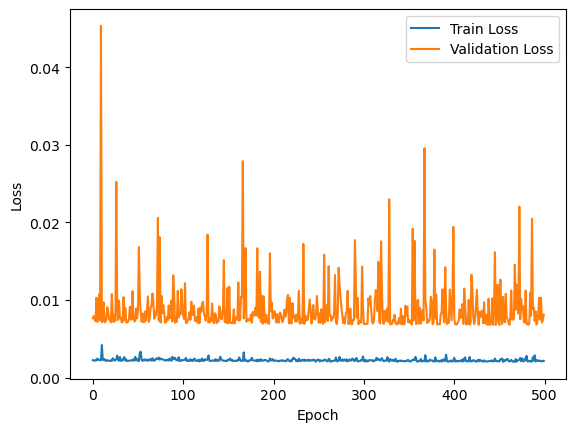

In [29]:
plot_history(history)

### With Early Stopping


..................................................
.....

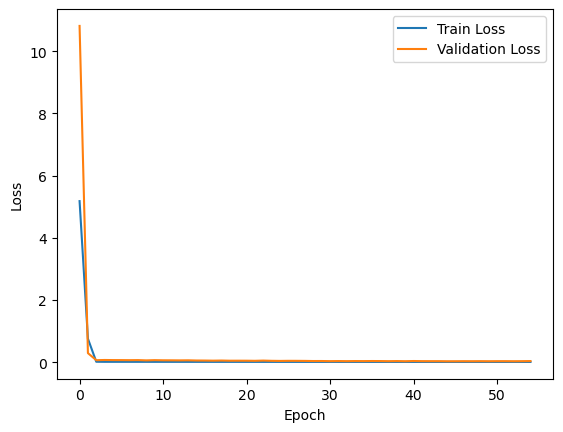

In [30]:
# model = build_model(): Mô hình được xây dựng bằng cách gọi hàm build_model() để tạo ra một mô hình mới.

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10): Đây là một callback được sử dụng để dừng quá trình huấn luyện sớm nếu không có sự cải thiện đủ lớn về loss function trên tập validation trong một khoảng patience (10 epochs trong trường hợp này). monitor='val_loss' chỉ ra rằng mô hình sẽ theo dõi loss function trên tập validation để quyết định khi nào dừng.

# history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()]): Mô hình được huấn luyện bằng cách sử dụng dữ liệu từ train_features và train_labels trong số lượng epochs đã được định nghĩa (n_epochs). Phần validation data được xác định bằng cách chia tập huấn luyện thành 80% cho huấn luyện và 20% cho validation (validation_split=0.2). Callback early_stop được sử dụng để dừng quá trình huấn luyện sớm nếu không có cải thiện đủ lớn trong loss function trên tập validation sau một số epochs nhất định. Callback PrintDot() cũng được sử dụng để in ra dấu chấm sau mỗi epoch.

# plot_history(history): Cuối cùng, hàm plot_history() được gọi để vẽ đồ thị biểu diễn sự tiến triển của loss function trên cả tập huấn luyện và tập validation.
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

## Test on test data

In [31]:

# Dòng mã này được sử dụng để đánh giá hiệu suất của mô hình trên tập kiểm tra (test_features và test_labels).

# model.evaluate(test_features, test_labels): Phương thức này tính toán loss function của mô hình trên tập kiểm tra bằng cách sử dụng dữ liệu đầu vào từ test_features và kết quả mong đợi từ test_labels. Kết quả của phương thức này là giá trị loss function trên tập kiểm tra.

# loss = model.evaluate(test_features, test_labels): Kết quả của model.evaluate() được gán cho biến loss.

# print("Mean Squared Error on test data = {}".format(loss)): Cuối cùng, kết quả loss function trên tập kiểm tra được in ra. Điều này cung cấp một ước lượng về hiệu suất của mô hình trên dữ liệu mới mà nó chưa từng thấy trong quá trình huấn luyện. Trong trường hợp này, giá trị được in ra là Mean Squared Error trên dữ liệu kiểm tra.





loss = model.evaluate(test_features, test_labels)
print("Mean Squared Error on test data = {}".format(loss))

17/17 [==============================] - 0s 1ms/step - loss: 0.2845
Mean Squared Error on test data = 0.2844609320163727


## Make Predictions

In [32]:
# Biến test_predictions chứa các dự đoán của mô hình trên tập kiểm tra (test_features).

# model.predict(test_features): Phương thức này được sử dụng để dự đoán kết quả dựa trên dữ liệu đầu vào từ test_features. Kết quả là một mảng numpy chứa các giá trị dự đoán tương ứng với mỗi mẫu trong tập kiểm tra.

# test_predictions.shape: Thuộc tính này trả về hình dạng (shape) của mảng test_predictions, tức là số lượng dự đoán và số chiều của mỗi dự đoán. Kết quả này cho biết rằng test_predictions có hình dạng là (n, 1), trong đó n là số lượng mẫu trong tập kiểm tra. Điều này chỉ ra rằng mỗi dự đoán được trả về dưới dạng một số nguyên 64-bit.
test_predictions = model.predict(test_features)
test_predictions.shape

17/17 [==============================] - 0s 2ms/step


(544, 1)

In [33]:
test_predictions[:10]

array([[7.9696503],
       [7.9513674],
       [7.939613 ],
       [7.955519 ],
       [7.868231 ],
       [7.810989 ],
       [7.791477 ],
       [7.73479  ],
       [7.668149 ],
       [7.569827 ]], dtype=float32)

In [34]:
test_predictions[:10]*denorm_const

array([[51.569546],
       [51.45124 ],
       [51.37518 ],
       [51.478107],
       [50.913284],
       [50.54289 ],
       [50.416634],
       [50.049824],
       [49.618607],
       [48.98239 ]], dtype=float32)

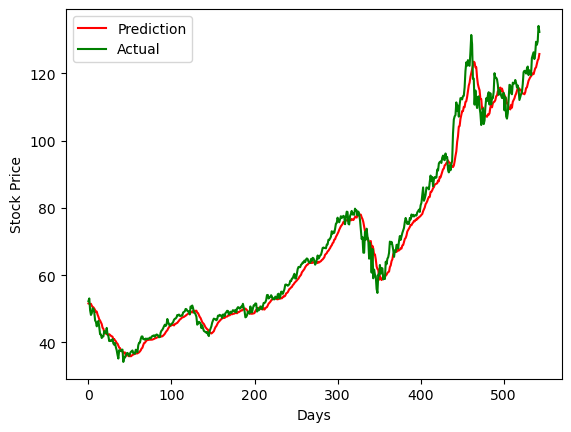

In [35]:
# plt.plot(test_predictions*denorm_const, 'r', label='Prediction'): Vẽ đường dự đoán với màu đỏ, được tính toán từ test_predictions, sau đó nhân với hằng số denorm_const để đưa dự đoán về dạng giá cổ phiếu ban đầu. Label của đường này là "Prediction".

# plt.plot(test_labels[0]*denorm_const, 'g', label='Actual'): Vẽ đường thực tế với màu xanh lá cây, được lấy từ test_labels, sau đó nhân với hằng số denorm_const để đưa giá trị thực tế về dạng giá cổ phiếu ban đầu. Label của đường này là "Actual".
plt.figure()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(test_predictions*denorm_const, 'r', label='Prediction')
plt.plot(test_labels[0]*denorm_const, 'g', label='Actual')
plt.legend()
plt.show()

In [36]:
# Mean Absolute Error (MAE): Đây là trung bình của giá trị tuyệt đối của sự khác biệt giữa giá trị dự đoán và giá trị thực tế. MAE càng nhỏ thì mô hình càng tốt.

# Root Mean Squared Error (RMSE): Đây là căn bậc hai của trung bình của bình phương của sự khác biệt giữa giá trị dự đoán và giá trị thực tế. RMSE cũng là một độ đo phổ biến để đánh giá hiệu suất của mô hình dự báo. Giống như MAE, giá trị RMSE càng nhỏ thì mô hình càng tốt.

# Mean Absolute Percentage Error (MAPE): Đây là trung bình của giá trị tuyệt đối của tỷ lệ phần trăm sự khác biệt giữa giá trị dự đoán và giá trị thực tế so với giá trị thực tế. MAPE thể hiện độ chính xác của dự báo theo phần trăm. MAPE càng nhỏ thì mô hình càng chính xác.

# Trong các độ đo trên, việc mô hình có MAE, RMSE và MAPE càng thấp thì cho thấy mô hình càng tốt.
mae = np.mean(np.abs(test_labels - test_predictions ))
print(mae)
rmse = np.sqrt(np.mean((test_labels - test_predictions) ** 2))
print(rmse)
#tính độ chính xác của dự báo
mape = np.mean(np.abs((test_labels - test_predictions )/ test_labels)) *100
print(mape)

0.3952244170819178
0.5333487657664137
3.5304915671952966


In [ ]:
# Mean Absolute Error (MAE): Khoảng cách trung bình giữa giá trị dự đoán và giá trị thực tế là khoảng 0.3952. Điều này cho thấy mô hình có xu hướng dự đoán giá trị gần với giá trị thực tế trên tập kiểm tra.

# Root Mean Squared Error (RMSE): Căn bậc hai của trung bình của bình phương của sự khác biệt giữa giá trị dự đoán và giá trị thực tế là khoảng 0.5333. RMSE cũng cho biết mức độ lệch lớn giữa giá trị dự đoán và giá trị thực tế trên tập kiểm tra.

# Mean Absolute Percentage Error (MAPE): Trung bình của giá trị tuyệt đối của tỷ lệ phần trăm sự khác biệt giữa giá trị dự đoán và giá trị thực tế so với giá trị thực tế là khoảng 3.5305%. MAPE cho biết mức độ sai lệch trung bình của mô hình so với giá trị thực tế trên tập kiểm tra, tính theo phần trăm. Điều này cho thấy mức độ sai lệch của mô hình là khoảng 3.5305%.